<a href="https://colab.research.google.com/github/chiaolun/vis-2025-spring/blob/main/2025.02.20%20-%20Elastic%20Collisions%20-%20Newtonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elastic Collision between two particles

In [2]:
import sympy as sp
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [175]:
# -------------------------------
# 1) Define symbolic expressions using Sympy
# -------------------------------

# Define symbolic variables for the positions
x1 = sp.symbols('x1', real=True)
wall_x = sp.symbols('wall_x', real=True)
r = sp.symbols('r', real=True)

# Define the repulsive potential energy, which is a constant push away from the wall after you hit it
# V = sp.Piecewise((0, x1 > wall_x), (-(x1 - wall_x), x1 <= wall_x)) * (1 +sp.sin(x1 - wall_x)**2)
V = sp.Piecewise(
    # (-2*r - 1, r <= -1), 
    (-r, r <= 0), 
    (0, True),
).subs(r, x1 - wall_x)

# V = sp.Piecewise((sp.exp(-5 * r), r > -1), (sp.exp(5), True)).subs(r, x1 - wall_x)

# Compute forces using Newton's second law: F = -dV/dx
F1 = -sp.diff(V, x1)

# Simplify expressions (they will be computed piecewise internally)
F1 = sp.simplify(F1)

display("F1:", F1)  # Expected to yield: F1 = -sign(x2 - x1) / |x2 - x1|^2

# Lambdify the force expressions for numerical evaluation
f1_func = sp.lambdify((x1, wall_x), F1, modules="numpy")

'F1:'

Piecewise((1, wall_x >= x1), (0, True))

<Axes: title={'center': 'Potential Energy vs Separation r'}, xlabel='x', ylabel='Potential Energy V'>

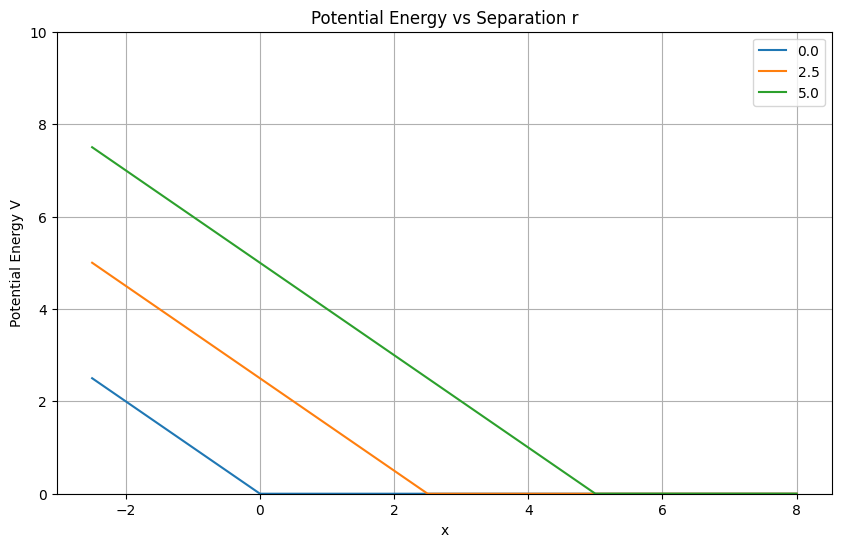

In [176]:
# Plot the potential energy
x_eval = np.linspace(-2.5, 8, 1000)
# Create potential functions for different wall positions
wall_x_values = [0, 2.5, 5]
V_funcs = {}
for wall_x_value in wall_x_values:
    V_funcs[wall_x_value] = sp.lambdify((x1,), V.subs(wall_x, wall_x_value), modules="numpy")(x_eval)

# Create DataFrame with all potentials
df = pd.DataFrame(V_funcs, index=x_eval)

# Plot using pandas
df.plot(
    figsize=(10, 6),
    xlabel='x',
    ylabel='Potential Energy V',
    title='Potential Energy vs Separation r',
    grid=True,
    ylim=(0, 10)
)

In [177]:
# -------------------------------
# 2) Define the ODE system using Newton's F = m*a
# -------------------------------

# Define masses
m1 = 1.0

def wall_position(t, wall_v):
    return wall_v * t

def system_newtonian(t, y, wall_v):
    """
    Compute the time-derivative of the state vector using Newtonian mechanics.

    The state vector is:
       y = [x1, x2, v1, v2]
    where
       dx1/dt = v1,
       dx2/dt = v2,
       dv1/dt = F1/m1,
       dv2/dt = F2/m2.
    The forces F1 and F2 are computed using the sympy-derived functions.
    """
    x1, v1 = y
    wall_x = wall_position(t, wall_v)
    F1 = f1_func(x1, wall_x)
    a1 = F1 / m1
    return [v1, a1]

In [178]:
# -------------------------------
# 3) Set up and solve the ODE system
# -------------------------------

# Initial conditions for positions and velocities
x1_0 = 2.0   # initial position of mass 1
v1_0 = -1.0      # initial velocity of mass 1
wall_v_0 = -0.5 # Wall velocity
y0 = [x1_0, v1_0]

# Define simulation time span
t_max = 10
t_eval = np.linspace(0, t_max, 1000)

# Solve the system using SciPy's solve_ivp
sol = solve_ivp(system_newtonian, [0, t_max], y0, t_eval=t_eval, rtol=1e-9, atol=1e-9, args=(wall_v_0,))
solution = pd.DataFrame(sol.y.T, columns=['x1', 'v1'], index=sol.t)
solution["wall_x"] = wall_position(solution.index, wall_v_0)
solution

,x1,v1,wall_x
0.00000,2.00000,-1.000000e+00,-0.000000
0.01001,1.98999,-1.000000e+00,-0.005005
0.02002,1.97998,-1.000000e+00,-0.010010
0.03003,1.96997,-1.000000e+00,-0.015015
0.04004,1.95996,-1.000000e+00,-0.020020
...,...,...,...
9.95996,-2.50000,-1.471176e-09,-4.979980
9.96997,-2.50000,-1.471176e-09,-4.984985
9.97998,-2.50000,-1.471176e-09,-4.989990
9.98999,-2.50000,-1.471176e-09,-4.994995


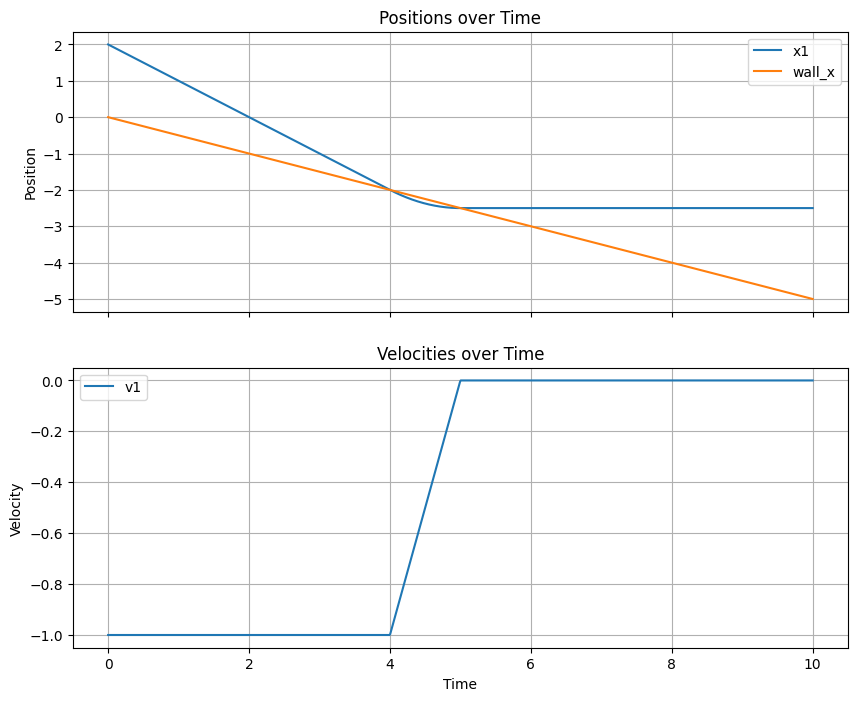

In [179]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Plot positions over time
solution[["x1", "wall_x"]].plot(xlabel='Time', ylabel='Position', title='Positions over Time', grid=True, ax=ax1)

# Plot velocities over time
solution[["v1"]].plot(xlabel='Time', ylabel='Velocity', title='Velocities over Time', grid=True, ax=ax2);

In [180]:
thinned_solution = solution.iloc[::5]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, height_ratios=[1, 5])

# Set axis limits for particle animation subplot
x_min = min(thinned_solution[['x1', 'wall_x']].min()) - 0.5
x_max = max(thinned_solution[['x1', 'wall_x']].max()) + 0.5
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(-1, 1)
ax1.set_title('Particle Collision')

# Create particle objects
particle1, = ax1.plot([], [], 'bo', markersize=5, label='Particle 1')
wall, = ax1.plot([], [], 'r-', linewidth=2, label='Wall')

# Set up position over time subplot
ax2.set_ylim(thinned_solution.index.max(), 0)  # Reversed y-axis limits to make time flow top to bottom
ax2.set_xlim(x_min, x_max)
ax2.set_title('Position vs Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Position')

# Plot full position data with flipped axes
ax2.plot(thinned_solution['x1'], thinned_solution.index, 'b-', label='Particle 1')
ax2.plot(thinned_solution['wall_x'], thinned_solution.index, 'r-', label='Wall')
ax2.legend()

# Create time indicator line
time_line, = ax2.plot([], [], 'g-', linewidth=1)

# Animation initialization function
def init():
    particle1.set_data([], [])
    wall.set_data([], [])
    time_line.set_data([], [])
    return particle1, wall, time_line

# Animation update function
def animate(frame):
    # Update particle position
    x_particle = thinned_solution.iloc[frame]['x1']
    particle1.set_data([x_particle], [0])
    
    # Update wall as a vertical line from y = -1 to y = 1
    x_wall = thinned_solution.iloc[frame]['wall_x']
    wall.set_data([x_wall, x_wall], [-1, 1])
    
    # Update time indicator line - now horizontal instead of vertical
    time = thinned_solution.index[frame]
    time_line.set_data([x_min, x_max], [time, time])
    
    return particle1, wall, time_line
# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(thinned_solution),
    interval=50,  # 50ms between frames
    blit=True,
    repeat=False  # Prevent repeating after animation ends
)
plt.close(fig)

# Display animation
HTML(anim.to_html5_video())
